In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import io
import json
import os
from pathlib import Path
from pprint import pprint
import requests
import sys
from typing import Optional

if '..' not in sys.path: sys.path.append('..')

from datasets import load_dataset
from datasets.arrow_dataset import Dataset
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pydantic_yaml import parse_yaml_file_as
import torch
from torch import nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer, AddedToken, PreTrainedTokenizer, AutoTokenizer


from mllm.utils.utils import read_tsv, write_tsv



# QnA datasets exploration
## Config and paths

In [4]:
DATA_PATH = Path(os.path.expandvars('$HOME')) / 'data'
HOTPOTQA_URL = 'http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_train_v1.1.json'
HOTPOTQA_DATA_PATH = DATA_PATH / 'hotpotqa'

HOTPOTQA_DATA_PATH.mkdir(exist_ok=True)

## Hotpot QA
### Load

In [5]:

def get_hotpotqa(url: str, dir_path: Path) -> pd.DataFrame:
    fname = url.split('/')[-1]
    fpath = dir_path / fname
    if fpath.exists():
        print(f'Load {fpath}')
        data = json.loads(fpath.read_text())
    else:
        print(f'Load {url}')
        resp = requests.get(url)
        data = resp.json()
        print(f'Write {fpath}')
        fpath.write_text(resp.text)
    df = pd.DataFrame.from_records(data)
    return df


In [6]:
df_hpqa = get_hotpotqa(HOTPOTQA_URL, HOTPOTQA_DATA_PATH)
df_hpqa

Load /home/misha/data/hotpotqa/hotpot_train_v1.1.json


,supporting_facts,level,question,context,answer,_id,type
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",Delhi,5a879ab05542996e4f30887e,bridge
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",President Richard Nixon,5a8d7341554299441c6b9fe5,bridge
3,"[[Peggy Seeger, 0], [Peggy Seeger, 1], [Ewan M...",medium,What nationality was James Henry Miller's wife?,"[[Moloch: or, This Gentile World, [Moloch: or,...",American,5a82171f5542990a1d231f4a,bridge
4,"[[Cadmium chloride, 1], [Ethanol, 0]]",medium,Cadmium Chloride is slightly soluble in this c...,"[[Cadmium chloride, [Cadmium chloride is a whi...",alcohol,5a84dd955542997b5ce3ff79,bridge
...,...,...,...,...,...,...,...
90442,"[[Kerry Remsen, 1], [Bert Remsen, 0]]",medium,Kerry Remsen is the daughter of an actor with ...,"[[Kerry Remsen, [Kerry Remsen is an American a...",American,5a8f8db25542997ba9cb32b9,bridge
90443,"[[Northshore Mall, 0], [Northshore Mall, 4], [...",easy,"Who manages both Northshore Mall in Peabody, M...","[[Green Tree Mall, [Green Tree Mall is a shopp...",Simon Property Group,5ae4f3615542993aec5ec0fd,bridge
90444,"[[Charlee Johnson, 4], [DreamWorks, 0]]",medium,Charlee Johnson was part of a band that signed...,"[[Simon M. Woods, [Simon M. Woods is a British...",Amblin Partners,5a903fc95542990a984935bd,bridge
90445,"[[Salt to the Sea, 1], [MV Wilhelm Gustloff, 0]]",medium,What is the ship that sank in the Baltic sea a...,[[The I.V. Stalin White Sea – Baltic Sea Canal...,"MV ""Wilhelm Gustloff",5ab56e71554299494045efc8,bridge


### Statistics

In [7]:
level_vc = df_hpqa.level.value_counts()
level_vc

level
medium    56814
easy      17972
hard      15661
Name: count, dtype: int64

<Axes: xlabel='level'>

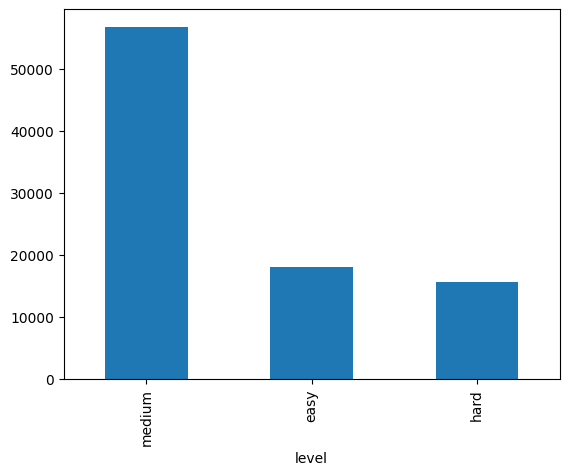

In [8]:
level_vc.plot.bar()

In [9]:
type_vc = df_hpqa.type.value_counts()
type_vc

type
bridge        72991
comparison    17456
Name: count, dtype: int64

<Axes: xlabel='type'>

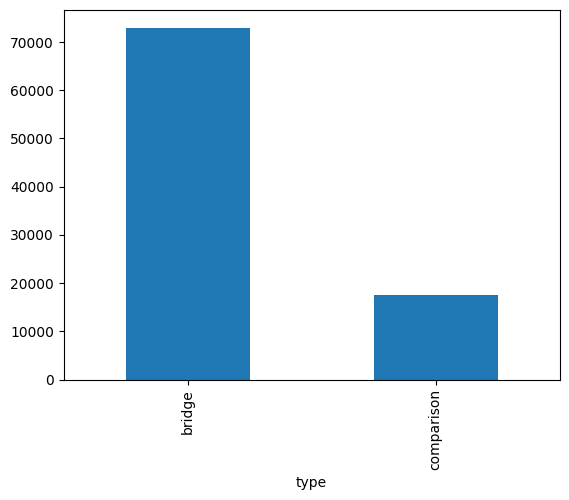

In [10]:
type_vc.plot.bar()

<Axes: xlabel='type,level'>

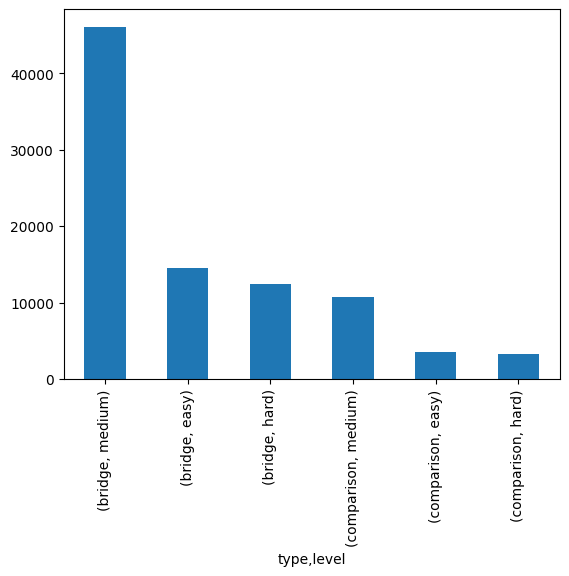

In [11]:
df_hpqa[['type', 'level']].value_counts().plot.bar()

### Comparison Questions

In [12]:
sample_question = df_hpqa[df_hpqa.type == 'comparison'].sample()
sample_question

,supporting_facts,level,question,context,answer,_id,type
82061,"[[Treasure Island (1950 film), 0], [That Darn ...",easy,"Which was filmed first, Treasure Island or Tha...","[[Silver (Andrew Motion novel), [Silver: Retur...",Treasure Island,5ae2c03e554299492dc91c5a,comparison


In [13]:
qrow = sample_question.iloc[0]
qrow.question

'Which was filmed first, Treasure Island or That Darn Cat?'

In [14]:
qrow.supporting_facts

[['Treasure Island (1950 film)', 0], ['That Darn Cat (1997 film)', 0]]

In [15]:
qrow.context

[['Silver (Andrew Motion novel)',
  ['Silver: Return to Treasure Island, is a novel by former British Poet Laureate Andrew Motion, published by Jonathan Cape on 15 March 2012.',
   ' The book follows Jim Hawkins, son of the character of the same name in Robert Louis Stevenson\'s 1883 novel "Treasure Island", as he and Nat, daughter of Long John Silver, also a character in "Treasure Island", return to the island visited by their fathers to claim abandoned bar silver.']],
 ['Treasure Island (1985 film)',
  ["Treasure Island (French: L'île au trésor ) is a 1985 adventure film directed by Chilean filmmaker Raúl Ruiz.",
   ' It was screened in the Un Certain Regard section at the 1991 Cannes Film Festival.',
   ' France, Great Britain and the United States funded Ruiz’s obscure and complex adaptation of the classic coming-of-age novel "Treasure Island" written by Robert Louis Stevenson.',
   ' "Treasure Island" stars Melvil Poupaud as Jim Hawkins/Jonathan, a familiar face in Ruiz filmograph

### Bridge Questions

In [16]:
sample_question = df_hpqa[(df_hpqa.type == 'bridge') & (df_hpqa.level == 'easy')].sample()
sample_question

,supporting_facts,level,question,context,answer,_id,type
82559,"[[Visceral Games, 0], [Visceral Games, 1], [De...",easy,Who created the horror media franchise that be...,"[[Paradigm Entertainment, [Paradigm Entertainm...",Glen Schofield,5ac55c915542993e66e8234f,bridge


In [17]:
qrow.question

'Which was filmed first, Treasure Island or That Darn Cat?'

In [18]:
qrow = sample_question.iloc[0]
qrow['supporting_facts']

[['Visceral Games', 0],
 ['Visceral Games', 1],
 ['Dead Space (series)', 0],
 ['Dead Space (series)', 2]]

In [19]:
qrow.context

[['Paradigm Entertainment',
  ['Paradigm Entertainment (previously part of Paradigm Simulation) was an American video game development company.',
   ' Paradigm is perhaps best known for its vehicle simulation games. Founded as a 3D computer graphics company in 1990, Paradigm primarily worked on realistic flight simulation technology for major space and aviation clients.',
   ' The company got its start in game development when it was contacted by Nintendo in 1994 to aid in the creation of one of the Nintendo 64\'s launch titles, "Pilotwings 64".',
   ' The game was a critical and commercial success for the developer, causing the simulation and entertainment divisions of Paradigm to separate and focus on their respective products.',
   " The newly independent Paradigm Entertainment continued to develop for Nintendo's 64-bit console.",
   ' After a short partnership with Video System, Paradigm was acquired as a wholly owned subsidiary of Infogrames in 2000 and began developing games for 

### Supporting Facts

In [20]:
df_hpqa['supporting_facts_num'] = df_hpqa.supporting_facts.map(len)
df_hpqa['supporting_facts_num'].describe()

count    90447.000000
mean         2.384645
std          0.672890
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: supporting_facts_num, dtype: float64

In [21]:
sup_facts_vc = df_hpqa['supporting_facts_num'].value_counts()
sup_facts_vc

supporting_facts_num
2     63676
3     20017
4      5814
5       724
6       141
7        52
8        17
9         4
12        1
11        1
Name: count, dtype: int64

<Axes: xlabel='supporting_facts_num'>

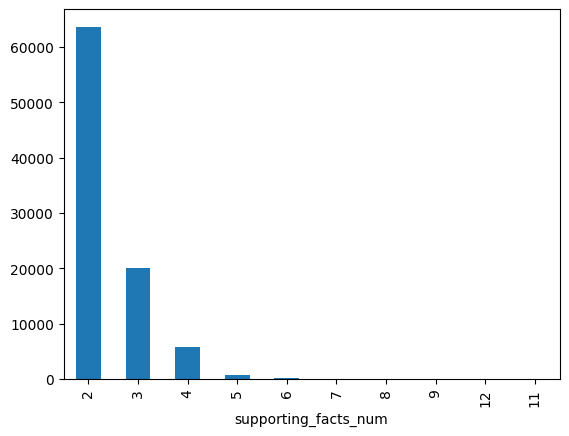

In [22]:
sup_facts_vc.plot.bar()

### Yes or No Questions

In [ ]:
yn_mask = df_hpqa.answer.str.startswith('yes') | df_hpqa.answer.str.startswith('no')
df_hpqa[yn_mask][['type', 'level']].value_counts()

type        level 
comparison  medium    3961
            hard      1034
            easy       533
bridge      hard        24
            medium      22
            easy        12
Name: count, dtype: int64

## Squad v2

In [5]:
ds_sq = load_dataset('squad_v2')
ds_sq

Downloading:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/9.55M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/801k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad_v2 downloaded and prepared to /home/misha/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [8]:
ds_sq_t, ds_sq_v = ds_sq['train'], ds_sq['validation']
ds_sq_t

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 130319
})

In [9]:
ds_sq_t[0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [17]:
item = ds_sq_v[1]
item

{'id': '56ddde6b9a695914005b9629',
 'title': 'Normans',
 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'question': 'When were the Normans in Normandy?',
 'answers': {'text': ['10th and 11th centuries',
   'in the 10th and 11th centuries',
   '10th and 11th centuries',
   '10th and 11th c

In [19]:
inds = set()
for ans_txt, ctx_ind in zip(item['answers']['text'], item['answers']['answer_start']):
    if ctx_ind in inds: continue
    inds.add(ctx_ind)
    ans_len = len(ans_txt)
    ctx_txt = item['context'][ctx_ind:ctx_ind + ans_len]
    ctx_off = 10
    ctx_ind_beg, ctx_ind_end = max(ctx_ind - ctx_off, 0), min(ctx_ind + ans_len + ctx_off, len(item['context']))
    ctx_txt_off = item['context'][ctx_ind_beg:ctx_ind_end]
    print(f'Answer: "{ans_txt}". Context answer: "{ctx_txt}", with offset: "{ctx_txt_off}"')

Answer: "10th and 11th centuries". Context answer: "10th and 11th centuries", with offset: "ho in the 10th and 11th centuries gave thei"
Answer: "in the 10th and 11th centuries". Context answer: "in the 10th and 11th centuries", with offset: "eople who in the 10th and 11th centuries gave thei"


In [20]:
ds_sq_t.features

{'id': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}

In [23]:
ds_sq_t[-22]

{'id': '5a7de9b570df9f001a87530a',
 'title': 'Matter',
 'context': 'Isaac Newton (1643–1727) inherited Descartes\' mechanical conception of matter. In the third of his "Rules of Reasoning in Philosophy", Newton lists the universal qualities of matter as "extension, hardness, impenetrability, mobility, and inertia". Similarly in Optics he conjectures that God created matter as "solid, massy, hard, impenetrable, movable particles", which were "...even so very hard as never to wear or break in pieces". The "primary" properties of matter were amenable to mathematical description, unlike "secondary" qualities such as color or taste. Like Descartes, Newton rejected the essential nature of secondary qualities.',
 'question': 'What did Descartes say were the universal qualities of matter?',
 'answers': {'text': [], 'answer_start': []}}